# NWTC site characterization through M4 and M5

## setup

In [1]:
import os, glob
import numpy as np
import pandas as pd
from calendar import monthrange, month_name
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import BoundaryNorm
import funcs as funcs
import datetime

import imp
import met_funcs as MET

In [2]:
%matplotlib inline
fs = 12
plt.rc('font', family='serif')
plt.rc('font', size=fs)


In [3]:
# paths (must mount volume smb://nrel.gov/shared/wind/WindWeb/MetData/135mData/M5Twr)
metPathLoHz = '/Volumes/M5Twr/10min/txt/'
figPath = '../../figs/'
# metPathLoHz = '/Volumes/shared/Wind/WindWeb/MetData/135mData/M5Twr/10min/txt/'

In [4]:
# time range
# years  = [ int(a) for a in np.arange(2012,2018,1) ] #
years = [2017]
months = [ int(a) for a in np.arange(1,12.1,1) ]

# READ IN DATA

In [ ]:
inputfiles = [] # list of files to be read into metdata object
filecount = 0

for year in years:
    for month in months:
        fName = glob.glob(os.path.join(metPathLoHz,'{0}_{1}.txt'.format(year,month_name[month])))        
        if len(fName)>0:
            fName = fName[0] 
            inputfiles.append(fName)
print('{} files to be read into MetData'.format(len(inputfiles)))

test = MET.load_met_data(inputfiles)
## remove columns that are all nans
MET.drop_nan_cols(test)
## use qc columns to mask data (qc != 1 => questionable data)
filt = MET.qc_mask(test)

12 files to be read into MetData


# DATA COMPLETENESS

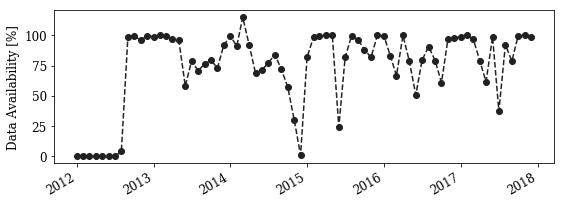

In [6]:
maxObs   = np.zeros(len(months)*len(years))
availObs = np.zeros(len(months)*len(years))
yearmonth = []
for iyear,year in enumerate(years):
    for imonth,month in enumerate(months):
        junk, ndays = monthrange(year,month)
        maxObs[iyear*12+imonth] = ndays*24*6

        t1 = str(pd.to_datetime('{0}{1:02d}{2:02d} 00:00'.format(year,month,1), format='%Y%m%d %H:%M'))
        t2 = str(pd.to_datetime('{0}{1:02d}{2:02d} 23:59'.format(year,month,ndays), format='%Y%m%d %H:%M'))        
        availObs[iyear*12+imonth] = len(test.loc[t1:t2])
        yearmonth.append(pd.to_datetime('{0}-{1}'.format(year,month)))
        
completeness = (availObs/maxObs)*100  
# also add yearly averaged completeness
# completeness = np.concatenate((completeness,np.mean(completeness,axis=1)[:,None]),axis=1)

fig, ax = plt.subplots()
ax.plot(yearmonth, completeness, ls='--', marker='o')
ax.xaxis_date()
ax.set_ylabel('Data availability [%]'.title())
fig.autofmt_xdate()
fig.set_size_inches(8,3)
fig.tight_layout()
fig.savefig(os.path.join(figPath,'M5_completeness_without_wdir_restriction_timeseries.png'),bbox_inches='tight')

In [7]:
# evaluate how complete the data are
maxObs   = np.zeros((len(months),len(years)))
availObs = np.zeros((len(months),len(years)))

for iyear,year in enumerate(years):
    for imonth,month in enumerate(months):

        junk, ndays = monthrange(year,month)
        maxObs[imonth,iyear] = ndays*24*6

        t1 = str(pd.to_datetime('{0}{1:02d}{2:02d} 00:00'.format(year,month,1), format='%Y%m%d %H:%M'))
        t2 = str(pd.to_datetime('{0}{1:02d}{2:02d} 23:59'.format(year,month,ndays), format='%Y%m%d %H:%M'))        
        availObs[imonth,iyear] = len(filt.loc[t1:t2])

completeness = (availObs/maxObs)*100  
# also add yearly averaged completeness
completeness = np.concatenate((completeness,np.mean(completeness,axis=1)[:,None]),axis=1)

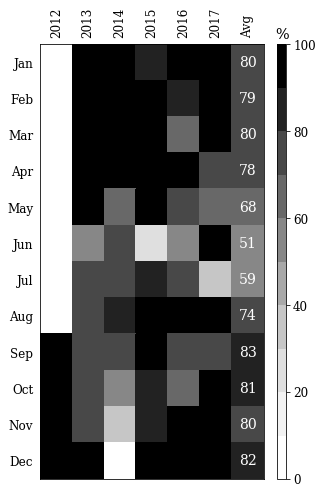

In [8]:
fig = plt.figure(figsize=(5,8))
ax  = fig.add_subplot(111)
cmap = plt.get_cmap('Greys')
norm = BoundaryNorm(np.arange(0.0,100.01,10), ncolors=cmap.N)
p = ax.pcolormesh(completeness,cmap='Greys',norm=norm)
ax.set_xticks([ i+0.5 for i in range(len(years)+1) ])
ax.set_xticklabels([str(y) for y in years]+['Avg'])
ax.xaxis.tick_top()
ax.set_yticks([ i+0.5 for i in range(len(months)) ])
ax.set_yticklabels([month_name[i][0:3] for i in months ])
labels = ax.get_xticklabels()
plt.setp(labels, rotation=90)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
ax.invert_yaxis()
clb = plt.colorbar(p,aspect=50)
clb.ax.set_title('%')

for im,month in enumerate(months):
        ax.text(len(years)+0.5,im+0.5,'{0:.0f}'.format(completeness[im,-1]),
                horizontalalignment='center',verticalalignment='center',
                color='w',fontsize=14)  

fig.savefig(os.path.join(figPath,'M5_completeness_without_wdir_restriction.png'),bbox_inches='tight')

### column names for various QOIs

In [7]:
imp.reload(MET)
varcats, varunits, varlabels, varsave = MET.categorize_fields(filt)

In [8]:
# filter TI to where wind speed >= 3 m/s
for ii,_ in enumerate(varcats['speed']):
    filt.loc[filt[varcats['speed'][ii]]<3,varcats['ti'][ii]] = np.nan

# filter obhukov length
for col in varcats['monin-obukhov length']:
    filt.loc[np.abs(filt[col])>2000, col] = np.nan
    
# filter sonic temperatures (kelvins vs degrees C)
for col in varcats['air temperature']:
    filt.loc[np.abs(filt[col])>200, col] = filt.loc[np.abs(filt[col])>200, col]-273

# filter gradient richardson number
for col in varcats['gradient richardson']:
    filt.loc[np.abs(filt[col])>20, col] = np.nan

# Profiles (cumulative and monthly)

In [13]:

for cat in varcats:
    fig, ax = MET.monthly_profile(filt, varcats[cat], basecolor='cycle')
    ax.set_xlabel(varlabels[cat])
    fig.tight_layout()
    fig.savefig(os.path.join(figPath,'profiles','{}_monthly_profile.png'.format(varsave[cat])), dpi=200, bbox_inches='tight')

    plt.close('all')
    
# cumulative profiles (kinda look like shit)
for cat in varcats:
    fig, ax = MET.cumulative_profile(filt, varcats[cat])#, basecolor='cycle')
    ax.set_xlabel(varlabels[cat])
    fig.tight_layout()
    fig.savefig(os.path.join(figPath,'profiles','{}_cumulative_profile.png'.format(varsave[cat])), dpi=200, bbox_inches='tight')

    plt.close('all')


# Roses


In [14]:
# get and SORT column names for wind speed and direction
dirs, dirlocs, _ = MET.get_vertical_locations(varcats['direction'])
spds, spdlocs, _ = MET.get_vertical_locations(varcats['speed'])

# wind speed bins to use in wind roses
bins = np.linspace(0,24,7)

for ind,height in enumerate(spdlocs):
    
    plotdat = filt[[dirs[ind],spds[ind]]]
    plotdat = plotdat.dropna(how='all',axis=1)
    if len(plotdat.columns)==1:
        print('skipping {} m'.format(height))
        continue

    fig, ax, leg = MET.rose_fig(plotdat[dirs[ind]],plotdat[spds[ind]], bins=bins)
    leg.set_title('Wind Speed [m/s]')
    ax.set_title('z = {} [m]'.format(height), x= 1.4,y=0.075)
    fig.tight_layout()

    fig.savefig(os.path.join(figPath,'windroses','windrose_{}m.png'.format(height)), dpi=200, bbox_inches='tight')
    
    plt.close('all')
    

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


skipping 30 m
skipping 55 m
skipping 80 m
skipping 105 m
skipping 130 m


# Scatter plots

In [ ]:
imp.reload(MET)

In [ ]:
dirs, dirlocs, _ = MET.get_vertical_locations(varcats['direction'])
spds, spdlocs, _ = MET.get_vertical_locations(varcats['speed'])
tis, tilocs, _ = MET.get_vertical_locations(varcats['ti'])

for ind,height in enumerate(spdlocs):
    plotdat = filt[[dirs[ind],spds[ind],tis[ind]]]
    plotdat = plotdat.dropna(how='all',axis=1)
    if len(plotdat.columns)<3:
        print('skipping {} m'.format(height))
        continue
    
    fig, ax = MET.winddir_scatter(plotdat[dirs[ind]],plotdat[spds[ind]])
    ax.set_ylabel('Wind Speed [m/s]')
    ax.set_ylim(0,40)
    fig.tight_layout()
    fig.savefig(os.path.join(figPath,'scatter','windspeed_scatter_{}m.png'.format(height)), dpi=200, bbox_inches='tight')
    
    fig, ax = MET.winddir_scatter(plotdat[dirs[ind]],plotdat[tis[ind]])
    ax.set_ylabel('TI [%]')
    ax.set_ylim(0,200)
    fig.tight_layout()
    fig.savefig(os.path.join(figPath,'scatter','TI_scatter_{}m.png'.format(height)), dpi=200, bbox_inches='tight')
    
    plt.close('all')

# cut by hour

In [15]:
for cat in varcats:
    fig, ax = MET.hourlyplot(filt, varcats[cat], basecolor='span')
    ax.set_ylabel(varlabels[cat])
    fig.savefig(os.path.join(figPath,'ave_day','{}.png'.format(varsave[cat])), dpi=200, bbox_inches='tight')

    plt.close('all')


# Cut by hour and month

In [16]:
for cat in varcats:
    fig, ax = MET.monthlyhourlyplot(filt, varcats[cat], basecolor='span')
    fig.text(0, 0.5, varlabels[cat], ha='center', va='center', rotation='vertical')
    fig.tight_layout()
    fig.savefig(os.path.join(figPath,'monthly','{}.png'.format(varsave[cat])), dpi=200, bbox_inches='tight')

    plt.close('all')

# ADD STABILITY FLAG AS A COLUMN

In [10]:
# tmp = filt[varcats['ti']+varcats['direction']+varcats['monin-obukhov length']].copy()

for col in varcats['monin-obukhov length']:
    z = int(col.split('m')[0].split('(')[-1])
    newcolname = 'Stability Flag ({}m)'.format(z)

    L = filt[col].copy()
    categoriesIdx = {'Very Stable': (L>0) & (L<=200),
                     'Stable' : (L>200) & (L<=500),
                     'Neutral' : (L<-500) | (L>500),
                     'Unstable' : (L>=-500) & (L<-200),
                     'Very Unstable': (L>=-200) & (L<0)}

    filt[newcolname] = np.nan
    for cat in categoriesIdx.keys():
        filt.loc[categoriesIdx[cat],newcolname] = cat
        
varcats['stability flag'] = [x for x in filt.columns if 'Stability Flag' in x]      

In [29]:
imp.reload(MET)

<module 'met_funcs' from '/Volumes/Sitechar/coderepo/nicholas/met_funcs.py'>

## scatter plots by height and stability

In [32]:
imp.reload(MET)
temp = np.zeros(0)
minmax = []
for col, _ in enumerate(varcats[cat]):
    temp = np.concatenate((temp, np.asarray(filt[varcats[cat][col]].dropna(how='any'))))
temp = MET.reject_outliers(temp, m=14)
minmax = [temp.min(), temp.max()]
# minmax = [MET.Round_To_n(temp.min(),0), MET.Round_To_n(temp.max(),3)]
print('plot limits for {} are:'.format(cat), minmax)

plot limits for air density are: [0.9006770000000001, 1.143034]


In [47]:
monthly_stability = filt[varcats['ti']].groupby([filt.index.month, filt[varcats['stability flag'][0]]])

In [50]:
colors = MET.get_colors(varcats['stability flag'], basecolor='span')
months = MET.monthnames()
fig, ax = plt.subplots(4,3, figsize=(9,9), sharex=True, sharey=True)

# for iax in range(len(months)):
#     for catitem in range(len('stability flag')):
#         ax.flatten()[iax].hist(monthly_stability[category[catitem]].xs(iax+1), color=colors[catitem])
#     ax.flatten()[iax].set_title(months[iax], fontsize=12)

# fig.text(0.5,0, 'Time of Day [hour]', ha='center', va='center')
# fig.legend(category, loc=6, bbox_to_anchor=(1, 0.5), edgecolor='w')
fig.tight_layout()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nhamilto/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-3cbf5701827b>", line 1, in <module>
    colors = MET.get_colors(varcats['stability flag'], basecolor='span')
  File "/Volumes/Sitechar/coderepo/nicholas/met_funcs.py", line 492, in get_colors
    cdict = polylinear_gradient(colors,ncolors+2)
TypeError: can only concatenate list (not "int") to list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nhamilto/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1828, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nhamilto

TypeError: can only concatenate list (not "int") to list

plot limits for air density are: [0.9006770000000001, 1.143034]
plot limits for air pressure are: [763.361794, 832.143853]
plot limits for air temperature are: [-25.236327999999986, 49.714707000000004]
plot limits for coherent tke are: [0.0006730000000000001, 9.571860000000001]
plot limits for cov(u_w) are: [-2.8190209999999998, 2.536756]
plot limits for cov(w_t) are: [-3.179307, 3.200532]
plot limits for direction are: [0.0, 359.99935899999997]
empty
empty
empty
empty
empty
plot limits for dissipation rate are: [0.0, 0.005584]
plot limits for gradient richardson are: [-18.664892000000002, 19.998739999999998]
plot limits for integral length scale (u) are: [-5.3e-05, 5.4000000000000005e-05]
plot limits for integral length scale (v) are: [-5e-05, 5.2000000000000004e-05]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nhamilto/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-10de403a140c>", line 44, in <module>
    fig.savefig(os.path.join(figPath,'scatter','stability','{}_scatter_{}m.png'.format(varsave[cat],heights[height])), dpi=200, bbox_inches='tight')
  File "/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/figure.py", line 1834, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/backend_bases.py", line 2267, in print_figure
    **kwargs)
  File "/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py", line 512, in print_png
    filename_or_obj = open(filename_or_obj, 'wb')
OSError: [Errno 57] Socket is not connected: '../../figs/scatter/stability/integral_length_scale_(v)_scatter_61m.png'

During handl

OSError: [Errno 57] Socket is not connected: '../../figs/scatter/stability/integral_length_scale_(v)_scatter_61m.png'

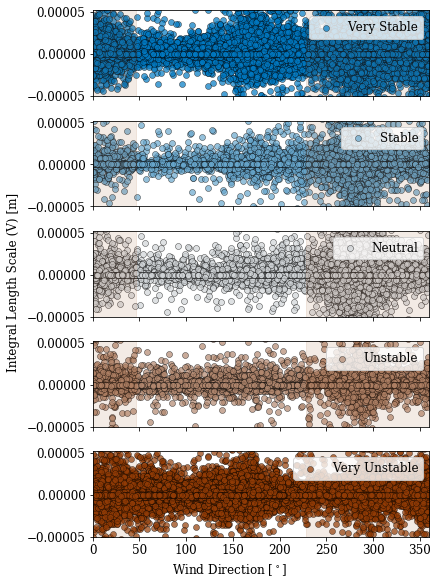

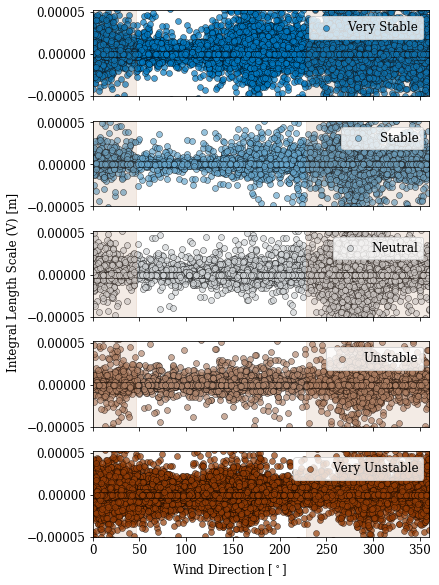

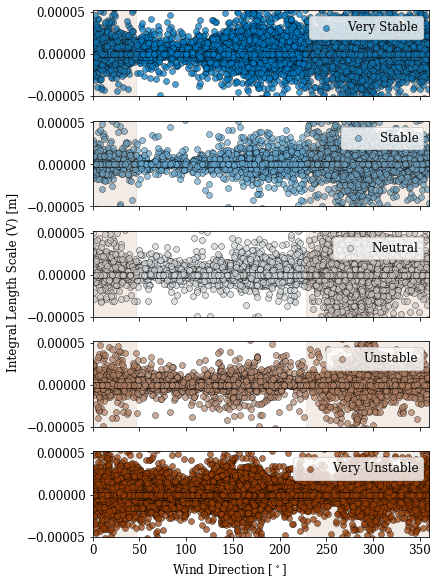

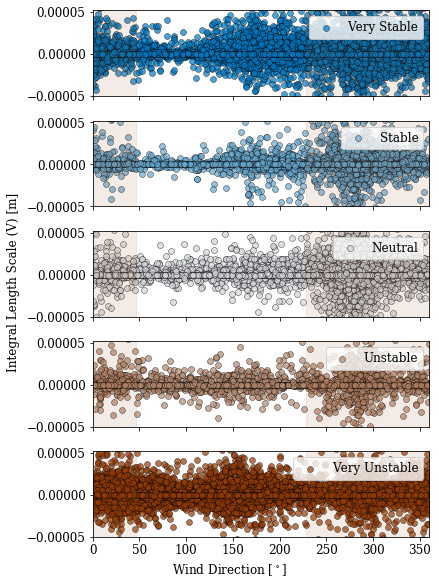

In [36]:
# test = tmp.copy()
colors = MET.get_colors(5,basecolor='span')
nrelcolors = MET.getnrelcolors()

for cat in varcats:

    dirind, catind, heights = MET.get_nearest_direction(filt, varcats['direction'], varcats[cat])
    _, stabind, _ = MET.get_nearest_stability(filt, varcats['stability flag'], varcats[cat])

    temp = np.zeros(0)
    minmax = []
    for col, _ in enumerate(varcats[cat]):
        temp = np.concatenate((temp, np.asarray(filt[varcats[cat][col]].dropna(how='any'))))
    temp = MET.reject_outliers(temp, m=5)
    minmax = [temp.min(), temp.max()]
#     minmax = [MET.Round_To_n(temp.min(),0), MET.Round_To_n(temp.max(),0)]
    print('plot limits for {} are:'.format(cat), minmax)
    
    for height in range(len(heights)):
        
        if len(filt[varcats['direction'][dirind[height]]].dropna(how='all')) == 0:
            print('empty')
            continue
        
        fig, ax = plt.subplots(5,1, sharex=True, sharey=True, figsize=(6,8))

        for ind, stabcond in enumerate(categoriesIdx.keys()):
            idx  = filt[varcats['stability flag'][1]]==stabcond

            ax.flatten()[ind].scatter(filt.loc[idx,varcats['direction'][dirind[height]]],filt.loc[idx,varcats[cat][catind[height]]],marker='o',facecolor=colors[ind],color='k',lw=0.5,alpha=0.7)#,label=labels[categ])
            ax.flatten()[ind].set_xlim([0,360])
            ax.flatten()[ind].set_ylim(minmax)
            ax.flatten()[ind].legend([stabcond], fontsize=12, loc=1)

            ax.flatten()[ind].axvspan(0, 46, alpha=0.1, color=nrelcolors['red'][0])
            ax.flatten()[ind].axvspan(228, 3600, alpha=0.1, color=nrelcolors['red'][0])


        fig.text(0.5,0, r'Wind Direction [$^\circ$]', ha='center', va='center')
        fig.text(0, 0.5, varlabels[cat], ha='center', va='center', rotation='vertical')

        fig.tight_layout()

        fig.savefig(os.path.join(figPath,'scatter','stability','{}_scatter_{}m.png'.format(varsave[cat],heights[height])), dpi=200, bbox_inches='tight')
    
    plt.close('all')
    
    

In [ ]:
# test = tmp.copy()

# fig, ax = MET.stability_winddir_scatter(test, 'TI', varcats)
# plt.subplots(5,1, sharex=True, sharey=True, figsize=(6,8))

# for ind, categ in enumerate(categoriesIdx.keys()):
#     idx  = test[varcats['stabflag'][1]]==categ
    
#     ax.flatten()[ind].scatter(test.loc[idx,varcats['winddir'][1]],test.loc[idx,varcats['TI'][0]],marker='o',facecolor=colors[ind],color='k',lw=0.5,alpha=0.7)#,label=labels[categ])
#     ax.flatten()[ind].set_xlim([0,360])
#     ax.flatten()[ind].set_ylim([0,120])
#     ax.flatten()[ind].legend([categ], fontsize=12, loc=1)
    
#     ax.flatten()[ind].axvspan(0, 46, alpha=0.1, color=nrelcolors['red'][0])
#     ax.flatten()[ind].axvspan(228, 3600, alpha=0.1, color=nrelcolors['red'][0])
    
    
# fig.text(0.5,0, r'Wind Direction [$^\circ$]', ha='center', va='center')
# fig.text(0, 0.5, catlabels['TI'], ha='center', va='center', rotation='vertical')
# # fig.legend(['Very Stable','Stable','Neutral','Unstable','Very Unstable'],loc=6, bbox_to_anchor=(1, 0.5), edgecolor='w')

# fig.tight_layout()



# FILTER OUT WIND DIRECTION ACCORDING TO IEC 

In [ ]:
# min and max wind directions
excludeAngleStart = 46.0
excludeAngleEnd   = 228.0
# min and max probe heights
zMinToConsider = 41.0
zMaxToConsider = 122.0

In [ ]:
wdir_cols

In [ ]:
# new dataframe filtering out wind directions according to the IEC
# same index as original dataframe
wdir_to_consider_in_excluding_data = pd.DataFrame(index=df.index)
# limit to 
for col in wdir_cols:
    z = float(col.split('m')[0].split('_')[-1]) 
    if ( (z>=zMinToConsider) and (z<=zMaxToConsider) ):
        wdir_to_consider_in_excluding_data[z] = df_qc[col].values

In [ ]:
vertical_avg_wdir = pd.Series(index=df.index)
for i in range(len(wdir_to_consider_in_excluding_data)):
    thisrow = wdir_to_consider_in_excluding_data.iloc[i]
    meanwdir = np.degrees(stats.circmean(np.radians(thisrow.dropna())))    
    vertical_avg_wdir.iloc[i] = meanwdir

In [ ]:
# identify the indices where the mean wind directions is outside of the allowed range.
idxToRemove = (vertical_avg_wdir>=excludeAngleStart) & (vertical_avg_wdir<=excludeAngleEnd)
print("These criteria will filter out {0:.1f}% of the data.".format(idxToRemove.sum()/float(len(idxToRemove))*100))

In [ ]:
df_qc_iec = df.copy()
df_qc_iec.loc[idxToRemove.values] = np.nan
df_qc_iec = df_qc_iec.dropna(how='all')

# AVERAGE BOUNDARY LAYER PROFILE

In [ ]:
cup_cols = [ x for x in wspd_cols if ('cup' in x.lower()) ]
sonic_cols = [ x for x in wspd_cols if ('sonic' in x.lower()) ]

both_df         = df_qc_iec[wspd_cols].copy()
both_df.columns = [ float(x.split('m')[0].split('_')[-1]) for x in both_df.columns ]

cup_df         = df_qc_iec[cup_cols].copy()
cup_df.columns = [ float(x.split('m')[0].split('_')[-1]) for x in cup_df.columns ]

sonic_df         = df_qc_iec[sonic_cols].copy()
sonic_df.columns = [ float(x.split('m')[0].split('_')[-1]) for x in sonic_df.columns ]

* all data (after qc/iec filters)

In [ ]:
len(sonic_df[100.0])

In [ ]:
fig = plt.figure(figsize=(4,6))
ax  = fig.add_subplot(111)

tmp = sonic_df.mean().sort_index()
ax.plot(tmp.values,tmp.index,'-o',ms=5,color=light_gray,label='sonics')

tmp = cup_df.mean().sort_index()
ax.plot(tmp.values,tmp.index,':o',ms=5,color='k',mec='k',label='cups')

ax.set_xlabel('Wind Speed [m/s]')
ax.set_ylabel('Height [m]')

plt.legend()

# fig.savefig(os.path.join(figPath,'M5_cup_vs_sonic_wspd_profile.png'),bbox_inches='tight')

In [ ]:
cup_cols = [ x for x in ti_cols if ('equivalent' not in x.lower()) ]
sonic_cols = [ x for x in ti_cols if ('equivalent' in x.lower()) ]

both_df         = df_qc_iec[ti_cols].copy()
both_df.columns = [ float(x.split('m')[0].split('_')[-1]) for x in both_df.columns ]

cup_df         = df_qc_iec[cup_cols].copy()
cup_df.columns = [ float(x.split('m')[0].split('_')[-1]) for x in cup_df.columns ]

sonic_df         = df_qc_iec[sonic_cols].copy()
sonic_df.columns = [ float(x.split('m')[0].split('_')[-1]) for x in sonic_df.columns ]

In [ ]:
fig = plt.figure(figsize=(4,6))
ax  = fig.add_subplot(111)

tmp = sonic_df.mean().sort_index()
ax.plot(tmp.values,tmp.index,'-o',ms=5,color=light_gray,label='sonics')

tmp = cup_df.mean().sort_index()
ax.plot(tmp.values,tmp.index,':o',ms=5,color='k',mec='k',label='cups')

ax.set_xlabel(ylabels['ti'])
ax.set_ylabel('Height [m]')

plt.legend()

# fig.savefig(os.path.join(figPath,'M5_cup_vs_sonic_wspd_profile.png'),bbox_inches='tight')

# CORRELATE STABILITY AND TI

In [ ]:
# L_cols

In [ ]:
# cat = pd.concat( [df_qc_iec['Monin-Obukhov Length (74m)'], 
#                   df_qc_iec['Ti (cup_ 80 m)'],
#                   df_qc_iec['Speed (cup_ 80 m)']], axis=1 )
# cat.columns = ['stability','ti','wspd']
# cat[cat.wspd<3] = np.nan
# cat = cat.dropna(how='any')

# plt.scatter(cat.stability.values,cat.ti.values)
# plt.xlim([-1500,1500])
# plt.ylim(0,120)

# WIND DIRECTION

In [ ]:
# heights = {'sonic':[15, 41, 61, 74, 100, 119],
#            'vane':[3, 10, 30, 38, 55, 80, 87, 105, 122, 130]}

# for dirType in heights.keys():
#     for z in heights[dirType]:

#         varName = [ x for x in df.columns if ( (str(z) in x) and (dirType in x.lower()) and ("direction" in x.lower()) and ("qc" not in x.lower()) and (("std" not in x.lower())) )]
        
#         if len(varName)==1:
        
#             varName = varName[0]
#             # several directions sensors produce only nans for some reason
#             if len(df[varName].dropna()) == 0:
#                 print('{0} only contains nan values.'.format(varName))
#                 continue
#             print(varName)
#             angles = df[varName].dropna()
#             fig = funcs.plot_rose(angles,titleStr="M5: {0} m ({1})".format(z,dirType))          
#             fig.tight_layout()
# #             fig.savefig(os.path.join(figPath,'M5_wdir_{0}_{1:.0f}m.png'.format(dirType,z)),bbox_inches='tight')

### BY MONTH

In [ ]:
# for month in months:
#     monthname = month_name[month]
#     idx = (df.index.month==month)
    
#     for dirType in heights.keys():
#         for z in heights[dirType]:
#             varName = [ x for x in df.columns if ( (str(z) in x) and (dirType in x.lower()) and ("direction" in x.lower()) and ("qc" not in x.lower()) and (("std" not in x.lower())) )]
#             if len(varName)==1:
#                 varName = varName[0]
#                 print(varName)
#                 angles = df[varName][idx].dropna()
#             fig = funcs.plot_rose(angles,titleStr="M5: {0:.0f} m ({1})\n{2}".format(z,dirType,monthname))            
# #             fig.savefig(os.path.join(figPath,'M5_wdir_{2}_{0}_{1:.0f}m.png'.format(dirType,z,monthname[0:3])),bbox_inches='tight')

### ALL INSTRUMENTS TOGETHER

In [ ]:
# heights = {'sonic': [15, 41, 61, 74, 100, 119],
#            'vane': [3, 10, 30, 38, 55, 80, 87, 105, 122, 130]}

# fig = plt.figure(figsize=(6,6))
# ax  = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
# ax.set_xticks(np.radians(np.arange(0,360,10)))
# ax.set_yticks([0,100])    

# ax.set_theta_offset((np.pi)/2)
# ax.set_theta_direction(-1)   
# ax.xaxis.get_majorticklabels()[0].set_visible(False)         

# for l in ax.yaxis.get_majorticklabels():
#     l.set_visible(False)

# # make some x ticks invisible
# xticks = ax.xaxis.get_majorticklabels()
# nticks = len(xticks)
# thetaticks = np.linspace(0,  360, 8, endpoint=False)
# ax.set_thetagrids(thetaticks, frac=1.2)    

# for dirType in heights.keys():
#     for z in heights[dirType]:
#         varName = [ x for x in df.columns if ( (str(z) in x) and (dirType in x.lower()) and ("direction" in x.lower()) and ("qc" not in x.lower()) and (("std" not in x.lower())) )]        
#         if len(varName)==1:
#             varName = varName[0] ; print varName
#             angles = df[varName].dropna()
#             angles[angles>=345] = angles[angles>=345] - 360.0
#             frqs, bins = np.histogram(angles.values,bins=np.arange(-15.0,345.1,30.0),density=True)
#             bins_centers = [ np.mean([bins[i],bins[i+1]]) for i in range(len(bins)-1) ]
#             bins = [ np.radians(b) for b in bins_centers ]
#             frqs = np.asarray([ float(f)/(sum(frqs)) for f in frqs ])
#             ax.bar(bins, frqs, alpha=1, width=np.radians(30.0), color='k', lw=2, fc='None', ec='k')
# ax.set_ylim([0,0.25])            
# ax.set_title("M5: all instruments, all data")
# fig.savefig(os.path.join(figPath,'M5_wdir_allInstrumentsOverlaid.png'),bbox_inches='tight')

In [ ]:
# heights = {'sonic':[15, 41, 61, 74, 100, 119],
#            'vane':[3, 10, 30, 38, 55, 80, 87, 105, 122, 130]}

# for month in months:
#     monthname = month_name[month]
#     idx = (df.index.month==month)

#     fig = plt.figure(figsize=(6,6))
#     ax  = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
#     ax.set_xticks(np.radians(np.arange(0,360,10)))
#     ax.set_yticks([0,100])    

#     ax.set_theta_offset((np.pi)/2)
#     ax.set_theta_direction(-1)   
#     ax.xaxis.get_majorticklabels()[0].set_visible(False)         

#     for l in ax.yaxis.get_majorticklabels():
#         l.set_visible(False)

#     # make some x ticks invisible
#     xticks = ax.xaxis.get_majorticklabels()
#     nticks = len(xticks)
#     thetaticks = np.linspace(0,  360, 8, endpoint=False)
#     ax.set_thetagrids(thetaticks, frac=1.2)    

#     for dirType in heights.keys():
#         for z in heights[dirType]:
#             varName = [ x for x in df.columns if ( (str(z) in x) and (dirType in x.lower()) and ("direction" in x.lower()) and ("qc" not in x.lower()) and (("std" not in x.lower())) )]        
#             if len(varName)==1:
#                 varName = varName[0] ; print varName
#                 angles = df[varName][idx].dropna()
#                 angles[angles>=345] = angles[angles>=345] - 360.0
#                 frqs, bins = np.histogram(angles.values,bins=np.arange(-15.0,345.1,30.0),density=True)
#                 bins_centers = [ np.mean([bins[i],bins[i+1]]) for i in range(len(bins)-1) ]
#                 bins = [ np.radians(b) for b in bins_centers ]
#                 frqs = np.asarray([ float(f)/(sum(frqs)) for f in frqs ])
#                 ax.bar(bins, frqs, alpha=1, width=np.radians(30.0), color='k', lw=2, fc='None', ec='k')
#     ax.set_ylim([0,0.25])
#     ax.set_title("M5: all instruments\n{0}".format(monthname))
#     fig.savefig(os.path.join(figPath,'M5_wdir_allInstrumentsOverlaid_{0}.png'.format(monthname[0:3])),bbox_inches='tight')

# WIND SPEED

* Diurnal cycle (OK)
    * Considering all (wdir-filtered) data, plotted by height (OK)
    * Considering all (wdir-filtered) data, plotted by month and by height (OK)

In [ ]:
# cmap = mpl.cm.get_cmap('viridis')

### DIURNAL CYCLE -- BY HEIGHT

In [ ]:
# diurnal_cycle = wspd_df.groupby(wspd_df.index.hour).mean()

In [ ]:
# fig = plt.figure(figsize=(6,6))
# ax  = fig.add_subplot(111)
# for iz,z in enumerate(np.sort(diurnal_cycle.columns)[::-1]):
#     ax.plot(diurnal_cycle[z], lw=(iz+1)*0.5, color=cmap(iz/float(len(diurnal_cycle.columns))),
#             label="{0:.0f} m".format(z))
# ax.set_yticks([3,4,5])    
# ax.set_xlabel('Time of Day [LT]')    
# ax.set_ylabel('Wind Speed [m/s]')
# plt.legend(bbox_to_anchor=(1.05,1.0),fontsize=13,frameon=False)
# ax.set_title('M5')
# fig.savefig(os.path.join(figPath,'M5_wspd_diurnalCycle_byHeight.png'),bbox_inches="tight")

### DIURNAL CYCLE -- BY HEIGHT, BY MONTH

In [ ]:
# fig = plt.figure(figsize=(12,15))

# axbig = fig.add_subplot(111)
# axbig.spines['top'].set_color('none')
# axbig.spines['bottom'].set_color('none')
# axbig.spines['left'].set_color('none')
# axbig.spines['right'].set_color('none')
# axbig.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
# axbig.set_xlabel('Time of Day [LT]',labelpad=15)    
# axbig.set_ylabel('Wind Speed [m/s]')
# axbig.set_title('M5',y=1.05)

# ax  = {}

# for im,month in enumerate(months):

#     monthname = month_name[month]
#     idx = (df.index.month==month)
#     subset = df[cols][idx]

#     diurnal_cycle = subset.groupby(subset.index.hour).mean()    
#     diurnal_cycle.columns = [ float(x.split('m')[0].split('_')[-1]) for x in diurnal_cycle.columns ]


#     ax[im]  = fig.add_subplot(4,3,im+1)
    
#     for iz,z in enumerate(np.sort(diurnal_cycle.columns)[::-1]):
#         ax[im].plot(diurnal_cycle[z], lw=(iz*0.5+1)*0.5, 
#                 color=cmap(iz/float(len(diurnal_cycle.columns))),#'k',
#                 label="{0:.0f} m".format(z))

#     ax[im].set_yticks([2,4,6,8,10])    
#     ax[im].set_ylim([1.25,10])
#     ax[im].set_xticks(np.arange(0,24,6))
#     ax[im].set_title('{0}'.format(monthname[0:3]))
#     ax[im].tick_params(axis='both', direction='in')
    
#     if im not in [9,10,11]:
#         plt.setp(ax[im].get_xticklabels(), visible=False)
#         plt.setp(ax[im].get_xlabel(), visible=False)       
    
#     if im not in [0,3,6,9]:
#         plt.setp(ax[im].get_yticklabels(), visible=False)
#         plt.setp(ax[im].get_ylabel(), visible=False)           
    
# ax[2].legend(bbox_to_anchor=(1.05,1.0),fontsize=13,frameon=False)
# fig.savefig(os.path.join(figPath,'M5_wspd_diurnalCycle_byHeight_{0}.png'.format(monthname[0:3])),bbox_inches="tight")    

* Vertical profile
    * Considering all (wdir-filtered) data, plotted by stabilty
    * Considering all (wdir-filtered) data, plotted by month
    * Considering all (wdir-filtered) data, plotted by time of day and by month    
* By month
* By TI
* By stability class
* By wind direction

### VERTICAL PROFILE -- BY STABILITY

In [ ]:
# for cat in categoriesIdx.keys():
#     idx = categoriesIdx[cat].values
#     stability.loc[idx,'category']  = cat

# wspd_df['stability'] = stability['category']

In [ ]:
# wspd_by_stability = wspd_df.groupby('stability').mean().T.sort_index()

In [ ]:
# fig = plt.figure(figsize=(5,8))
# ax  = fig.add_subplot(111)
# for key in wspd_by_stability.columns:
#     ax.plot(wspd_by_stability[key].values,wspd_by_stability[key].index,label=key)
# plt.legend()

In [ ]:
# stability

In [ ]:
# wspd_df.loc['2012-08-30 20:30:00-06:00']

### HEIGHT

### TI 

### STABILITY

### WIND DIRECTION

In [ ]:
# list(diurnal_cycle.columns)

In [ ]:
# varName = 'd(u)/d(t) (sonic_61m)'

# fig = plt.figure(figsize=(6,5))
# ax  = fig.add_subplot(111)
# ax.plot(diurnal_cycle[varName],'-.k')
# ax.set_xlabel('Hour of Day')
# ax.set_ylabel(varName)

In [ ]:
# print(metPathLoHz)